In [4]:
import pathlib

import movingpandas as mpd
import geopandas as gpd

import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


In [2]:
import dask.dataframe as dd

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55847,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:55860,Total threads: 2
Dashboard: http://127.0.0.1:55861/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:55850,


In [3]:
locks_df = gpd.read_file('./locks.json')
locks = locks_df.query('water=="lock"')
gates = locks_df.query('waterway=="lock_gate"')

DriverError: ./locks.json: No such file or directory

In [3]:
ddf = dd.read_parquet('./mmsi-parquet')
ddf.groupby('mmsi').count().sort_values('latitude', ascending=False).head(n=20)

,messageType,timestampReceived,objectType,longitude,latitude,positionValid,sog,sogValid,cog,cogValid,...,length,beam,draughtInland,draughtMarine,hazardousCargo,loaded,shiptype,numberCrew,numberPassengers,numberPersonnel
mmsi,,,,,,,,,,,,,,,,,,,,,
244690813,162114,162114,162114,162114,162114,162114,162114,162114,162114,162114,...,161899,161899,161899,161919,161899,0,0,0,0,0
244700510,124493,124493,124493,124493,124493,124493,124493,124493,124493,124493,...,124400,124400,124400,123726,124400,124400,0,0,0,0
244690617,108266,108266,108266,108266,108266,108266,108266,108266,108266,108266,...,108175,108175,108175,108177,108175,108175,0,0,0,0
244615821,103731,103731,103731,103731,103731,103731,103731,103731,103731,103731,...,103620,103620,103620,103621,0,103620,0,0,0,0
244670537,100488,100488,100488,100488,100488,100488,100488,100488,100488,100488,...,100364,100364,100364,100367,0,100364,0,0,0,0
243990530,91178,91178,91178,91178,91178,91178,91178,91178,91178,91178,...,91018,91018,91018,0,91018,0,0,0,0,0
244710947,57123,57123,57123,57123,57123,57123,57123,57123,57123,57123,...,56942,56942,7,167,0,56942,0,0,0,0
246536000,56008,56008,56008,56008,56008,56008,56008,56008,56008,56008,...,55989,55989,55989,55992,55989,0,55076,0,0,0
205336190,40247,40247,40247,40247,40247,40247,40247,40247,40247,40247,...,0,0,0,0,40193,0,0,0,0,0


In [87]:
selected = ddf.loc[[14155114,367661830, 244690813, 244700510, 244690617, 244615821, 244670537, 243990530, 244710947]]

# 244615821, 244670537 => police vessel

In [88]:
def trajectories(df):
    return df.shape[0]
selected.groupby('mmsi').apply(trajectories, meta=('x', 'int')) .compute()

mmsi
14155114        374
243990530     91178
244615821    103731
244670537    100488
244690617    108266
244690813    162114
244700510    124493
244710947     57123
367661830       301
Name: x, dtype: int64

In [89]:
df = selected.loc[244710947].compute()

In [90]:
mmsi = df.index[0]
# convert to UTC and drop TZ info
df['t'] = df['timestamplast'].dt.tz_convert(None)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='EPSG:4326'))
mdf = mpd.Trajectory(gdf.set_index('t'), traj_id=mmsi)

In [91]:
m_per_degree = 111267.31 # at 52N
# downscale to 5m resolution 
mdf = mpd.DouglasPeuckerGeneralizer(mdf).generalize(tolerance=5/m_per_degree)

In [92]:

mdf_splitted = mpd.ObservationGapSplitter(mdf).split(gap=datetime.timedelta(hours=6))
mdf_splitted
mdf = mdf_splitted.trajectories[0]


In [93]:

# determine which locks intersects
locks_intersects = locks['geometry'].apply(mdf.intersects)
# did we pass any locks
passed_lock = locks_intersects.sum() > 0
if passed_lock:
    feature = next(locks[locks_intersects].iterfeatures())
    intersections = mdf.intersection(feature)
    intersection = intersections.trajectories[0]
    duration = intersection.get_duration()

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/movingpandas/overlay.py:101: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  row0 = traj.df.iloc[traj.df.index.get_loc(range.t_0, method="pad")].copy()
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/movingpandas/overlay.py:104: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  rown = traj.df.iloc[traj.df.index.get_loc(range.t_n, method="pad")].copy()


(51.688575695, 51.694841405)

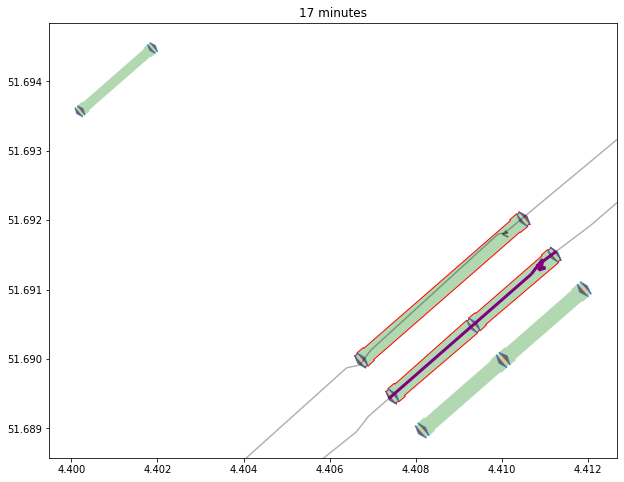

In [96]:

fig, ax = plt.subplots(figsize=(13, 8))
locks.plot(ax=ax, alpha=0.3, facecolor='green')
gates.plot(ax=ax, alpha=0.8, facecolor='brown')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
# plot locks that this ship passes through
if passed_lock:
    locks[locks_intersects].plot(edgecolor='red', ax=ax, facecolor='none')
mdf.plot(ax=ax, alpha=0.3, color='black')
if passed_lock:
    intersection.plot(ax=ax, linewidth=3, edgecolor='purple')
    ax.set_title(f"{duration.total_seconds() /60:.0f} minutes")
ax.set_xlim(xlim)
ax.set_ylim(ylim)


(51.689212635000004, 51.692256664999995)

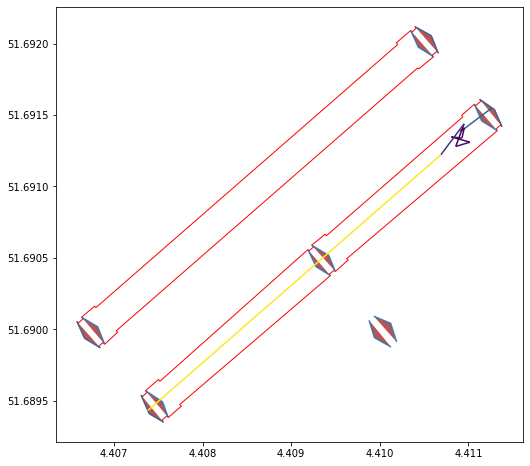

In [95]:


fig, ax = plt.subplots(figsize=(13, 8))
locks[locks_intersects].plot(edgecolor='red', ax=ax, facecolor='none')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gates.plot(ax=ax, alpha=0.8, facecolor='brown')

for traj in mpd.StopSplitter(intersection).split(min_duration=datetime.timedelta(seconds=120), max_diameter=10):
    traj.plot(ax=ax, column='speed')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)